# Quantum Finance - Agente de Reinforcement Learning para Trading

## Projeto Integrado: Operação de Ativos com RL

**Objetivo:** Criar um agente de RL que opere 3 ativos (Vale, Petrobras, BRF) para maximizar o lucro em 6 meses.

**Ativos:** VALE3.SA, PETR4.SA, BRFS3.SA

**Capital Inicial:** R$ 10.000,00


# Fase 1: Preparação e Configuração


In [1]:
# Instalação de bibliotecas necessárias (executar apenas se necessário)
# !pip install yfinance gymnasium tensorflow pandas numpy matplotlib seaborn


In [2]:
# Importações essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from collections import deque
import random
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces

# Configuração de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Sementes para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Bibliotecas importadas com sucesso!")
print(f"TensorFlow versão: {tf.__version__}")
print(f"Pandas versão: {pd.__version__}")


2025-11-02 16:04:37.235397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Bibliotecas importadas com sucesso!
TensorFlow versão: 2.20.0
Pandas versão: 2.3.3


## 1.1. Obter e Preparar os Dados


In [3]:
# Definir os tickers das ações na B3
tickers = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']
nomes_acoes = ['Vale', 'Petrobras', 'BRF']

# Período de dados: 2018 a 2023
data_inicio = '2014-01-01'
data_fim = '2024-12-31'

print("Baixando dados históricos...")
dados_acoes = {}

for ticker in tickers:
    try:
        acao = yf.download(ticker, start=data_inicio, end=data_fim, progress=False)
        if not acao.empty:
            dados_acoes[ticker] = acao
            print(f"✓ {ticker}: {len(acao)} dias de dados (de {acao.index[0].date()} a {acao.index[-1].date()})")
        else:
            print(f"✗ {ticker}: Dados não disponíveis")
    except Exception as e:
        print(f"✗ Erro ao baixar {ticker}: {e}")

print(f"\nTotal de ações carregadas: {len(dados_acoes)}")


Baixando dados históricos...
✓ VALE3.SA: 2735 dias de dados (de 2014-01-02 a 2024-12-30)
✓ PETR4.SA: 2735 dias de dados (de 2014-01-02 a 2024-12-30)
✓ BRFS3.SA: 2735 dias de dados (de 2014-01-02 a 2024-12-30)

Total de ações carregadas: 3


In [4]:
# Preparar DataFrame consolidado com preços, volumes e indicadores técnicos
def calcular_obv(precos, volumes):
    """Calcula o On-Balance Volume (OBV)."""
    # Garantir que são Series simples
    if isinstance(precos, pd.DataFrame):
        precos = precos.iloc[:, 0]
    if isinstance(volumes, pd.DataFrame):
        volumes = volumes.iloc[:, 0]
    
    precos = pd.Series(precos) if not isinstance(precos, pd.Series) else precos
    volumes = pd.Series(volumes) if not isinstance(volumes, pd.Series) else volumes
    
    obv = pd.Series(0.0, index=precos.index)
    
    # Converter para numpy array para comparações mais rápidas
    precos_vals = precos.values
    volumes_vals = volumes.values
    
    obv.iloc[0] = volumes_vals[0]
    
    for i in range(1, len(precos)):
        if precos_vals[i] > precos_vals[i-1]:
            obv.iloc[i] = obv.iloc[i-1] + volumes_vals[i]
        elif precos_vals[i] < precos_vals[i-1]:
            obv.iloc[i] = obv.iloc[i-1] - volumes_vals[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]
    
    return obv

# Dicionário para armazenar todos os dados
dados_completos = {}

for ticker, nome in zip(tickers, nomes_acoes):
    if ticker in dados_acoes:
        df_temp = pd.DataFrame(index=dados_acoes[ticker].index)
        
        # Preço de fechamento
        df_temp[f'{nome}_preco'] = dados_acoes[ticker]['Close']
        
        # Volume
        df_temp[f'{nome}_volume'] = dados_acoes[ticker]['Volume']
        
        # Médias móveis
        df_temp[f'{nome}_mm8'] = dados_acoes[ticker]['Close'].rolling(window=8).mean()
        df_temp[f'{nome}_mm20'] = dados_acoes[ticker]['Close'].rolling(window=20).mean()
        df_temp[f'{nome}_mm200'] = dados_acoes[ticker]['Close'].rolling(window=200).mean()
        
        # OBV (On-Balance Volume)
        df_temp[f'{nome}_obv'] = calcular_obv(
            dados_acoes[ticker]['Close'],
            dados_acoes[ticker]['Volume']
        )
        
        dados_completos[nome] = df_temp

# Combinar todos os dados em um único DataFrame
dados_mercado = pd.DataFrame(index=dados_acoes[tickers[0]].index)

for nome in nomes_acoes:
    if nome in dados_completos:
        for col in dados_completos[nome].columns:
            dados_mercado[col] = dados_completos[nome][col]

# Remover linhas com valores NaN (especialmente devido à MM200 que precisa de 200 períodos)
dados_mercado = dados_mercado.dropna()

# Alinhar todas as datas
dados_mercado = dados_mercado.sort_index()

print(f"Dataset final: {len(dados_mercado)} dias de dados")
print(f"Período: {dados_mercado.index[0].date()} a {dados_mercado.index[-1].date()}")
print(f"\nColunas disponíveis: {list(dados_mercado.columns)}")
print("\nPrimeiras linhas:")
dados_mercado.head(10)


Dataset final: 2536 dias de dados
Período: 2014-10-20 a 2024-12-30

Colunas disponíveis: ['Vale_preco', 'Vale_volume', 'Vale_mm8', 'Vale_mm20', 'Vale_mm200', 'Vale_obv', 'Petrobras_preco', 'Petrobras_volume', 'Petrobras_mm8', 'Petrobras_mm20', 'Petrobras_mm200', 'Petrobras_obv', 'BRF_preco', 'BRF_volume', 'BRF_mm8', 'BRF_mm20', 'BRF_mm200', 'BRF_obv']

Primeiras linhas:


,Vale_preco,Vale_volume,Vale_mm8,Vale_mm20,Vale_mm200,Vale_obv,Petrobras_preco,Petrobras_volume,Petrobras_mm8,Petrobras_mm20,Petrobras_mm200,Petrobras_obv,BRF_preco,BRF_volume,BRF_mm8,BRF_mm20,BRF_mm200,BRF_obv
Date,,,,,,,,,,,,,,,,,,
2014-10-20,13.077573,3536400,13.077985,13.002418,14.428367,-55564300.0,4.925146,70794896,5.523955,5.411751,4.755754,294178104.0,52.960648,1903236,53.731920,52.780243,45.122264,16594295.0
2014-10-21,13.191118,7486500,13.126952,13.006541,14.413779,-48077800.0,4.644807,105185600,5.376228,5.367365,4.757436,188992504.0,51.090096,3645426,53.268714,52.781129,45.164283,12948869.0
2014-10-22,13.210864,4102300,13.208125,13.009510,14.401026,-43975500.0,4.565105,62049400,5.258046,5.317618,4.759040,126943104.0,52.118458,2302120,53.080329,52.864018,45.217380,15250989.0
2014-10-23,13.452768,6933500,13.254707,13.031474,14.389413,-37042000.0,4.262780,110386000,5.030616,5.258115,4.758979,16557104.0,50.992573,3859523,52.643718,52.907014,45.264541,11391466.0
2014-10-24,13.551502,7082000,13.264859,13.067414,14.380237,-29960000.0,4.567852,100322000,4.859527,5.198750,4.761035,116879104.0,50.708885,2962585,52.186051,52.856039,45.309183,8428881.0
2014-10-27,13.062760,13445200,13.214514,13.089148,14.368085,-43405200.0,3.990687,215365600,4.666108,5.142682,4.760167,-98486496.0,50.912785,5328367,51.798198,52.828557,45.361881,13757248.0
2014-10-28,12.904784,7366700,13.199140,13.095607,14.357897,-50771900.0,4.130856,95132900,4.541743,5.100632,4.760629,-3353596.0,52.402142,2850809,51.824794,52.867121,45.427744,16608057.0
2014-10-29,12.223505,10871400,13.084359,13.068478,14.344395,-61643300.0,3.853267,89851000,4.367563,5.058443,4.759356,-93204596.0,52.747887,2437953,51.741684,52.900365,45.497974,19046010.0
2014-10-30,11.700207,5656900,12.912189,12.996628,14.328762,-67300200.0,3.935720,75048900,4.243884,5.017492,4.758753,-18155696.0,54.325890,2936637,51.912339,52.989461,45.574159,21982647.0


Dados de Treino: 2037 dias (2014-10-20 a 2022-12-29)
Dados de Teste: 124 dias (2023-01-02 a 2023-06-30)


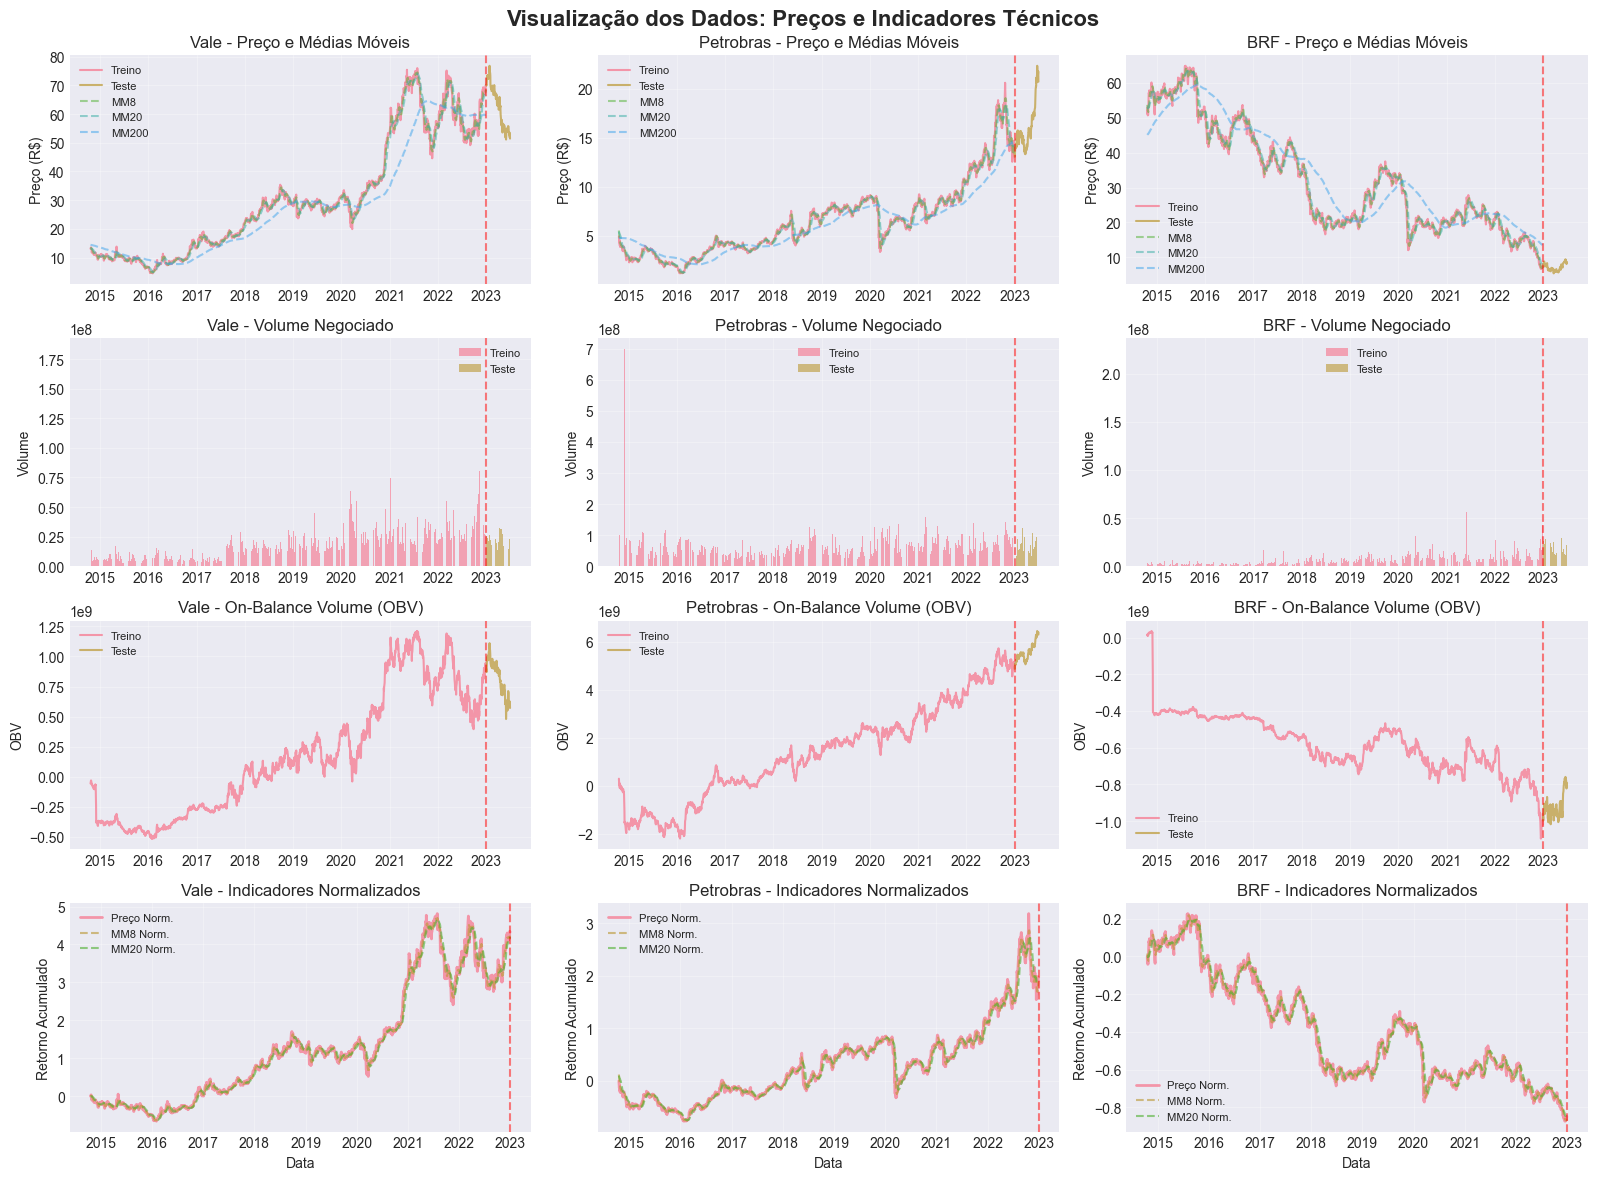

In [5]:
# Divisão Treino/Teste
# Treino: 2018 a 2022
# Teste: Primeiros 6 meses de 2023

data_corte_treino = '2023-01-01'
data_corte_teste = '2023-07-01'

dados_treino = dados_mercado[dados_mercado.index < data_corte_treino].copy()
dados_teste = dados_mercado[(dados_mercado.index >= data_corte_treino) & (dados_mercado.index < data_corte_teste)].copy()

print(f"Dados de Treino: {len(dados_treino)} dias ({dados_treino.index[0].date()} a {dados_treino.index[-1].date()})")
print(f"Dados de Teste: {len(dados_teste)} dias ({dados_teste.index[0].date()} a {dados_teste.index[-1].date()})")

# Visualizar os dados (preços e indicadores)
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
fig.suptitle('Visualização dos Dados: Preços e Indicadores Técnicos', fontsize=16, fontweight='bold')

for idx, nome in enumerate(nomes_acoes):
    # Preços
    col_preco = f'{nome}_preco'
    if col_preco in dados_treino.columns:
        axes[0, idx].plot(dados_treino.index, dados_treino[col_preco], label='Treino', alpha=0.7, linewidth=1.5)
        axes[0, idx].plot(dados_teste.index, dados_teste[col_preco], label='Teste', alpha=0.7, linewidth=1.5)
        axes[0, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm8'], label='MM8', alpha=0.5, linestyle='--')
        axes[0, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm20'], label='MM20', alpha=0.5, linestyle='--')
        axes[0, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm200'], label='MM200', alpha=0.5, linestyle='--')
        axes[0, idx].axvline(x=pd.Timestamp(data_corte_treino), color='red', linestyle='--', alpha=0.5)
        axes[0, idx].set_title(f'{nome} - Preço e Médias Móveis')
        axes[0, idx].set_ylabel('Preço (R$)')
        axes[0, idx].legend(fontsize=8)
        axes[0, idx].grid(True, alpha=0.3)
    
    # Volume
    col_volume = f'{nome}_volume'
    if col_volume in dados_treino.columns:
        axes[1, idx].bar(dados_treino.index, dados_treino[col_volume], alpha=0.6, width=1, label='Treino')
        axes[1, idx].bar(dados_teste.index, dados_teste[col_volume], alpha=0.6, width=1, label='Teste')
        axes[1, idx].axvline(x=pd.Timestamp(data_corte_treino), color='red', linestyle='--', alpha=0.5)
        axes[1, idx].set_title(f'{nome} - Volume Negociado')
        axes[1, idx].set_ylabel('Volume')
        axes[1, idx].legend(fontsize=8)
        axes[1, idx].grid(True, alpha=0.3)
    
    # OBV
    col_obv = f'{nome}_obv'
    if col_obv in dados_treino.columns:
        axes[2, idx].plot(dados_treino.index, dados_treino[col_obv], label='Treino', alpha=0.7, linewidth=1.5)
        axes[2, idx].plot(dados_teste.index, dados_teste[col_obv], label='Teste', alpha=0.7, linewidth=1.5)
        axes[2, idx].axvline(x=pd.Timestamp(data_corte_treino), color='red', linestyle='--', alpha=0.5)
        axes[2, idx].set_title(f'{nome} - On-Balance Volume (OBV)')
        axes[2, idx].set_ylabel('OBV')
        axes[2, idx].legend(fontsize=8)
        axes[2, idx].grid(True, alpha=0.3)
    
    # Médias móveis normalizadas
    if col_preco in dados_treino.columns:
        axes[3, idx].plot(dados_treino.index, dados_treino[col_preco] / dados_treino[col_preco].iloc[0] - 1, 
                         label='Preço Norm.', alpha=0.7, linewidth=2)
        axes[3, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm8'] / dados_treino[col_preco].iloc[0] - 1, 
                         label='MM8 Norm.', alpha=0.6, linestyle='--')
        axes[3, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm20'] / dados_treino[col_preco].iloc[0] - 1, 
                         label='MM20 Norm.', alpha=0.6, linestyle='--')
        axes[3, idx].axvline(x=pd.Timestamp(data_corte_treino), color='red', linestyle='--', alpha=0.5)
        axes[3, idx].set_title(f'{nome} - Indicadores Normalizados')
        axes[3, idx].set_ylabel('Retorno Acumulado')
        axes[3, idx].set_xlabel('Data')
        axes[3, idx].legend(fontsize=8)
        axes[3, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Fase 2: Modelagem do Problema - Ambiente Customizado


In [6]:
class StockTradingEnv(gym.Env):
    """
    Ambiente customizado de Reinforcement Learning para trading de ações.
    
    Estados: [saldo, n_vale, n_petro, n_brf, 
              para cada ação (Vale, Petro, BRF): preco, volume, mm8, mm20, mm200, obv]
    Total: 4 + (3 * 6) = 22 dimensões
    
    Ações: 0=Manter, 1=Comprar Vale, 2=Vender Vale, 3=Comprar Petro, 4=Vender Petro, 5=Comprar BRF, 6=Vender BRF
    Recompensa: Mudança no valor total do portfólio
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(self, dados_mercado, capital_inicial=10000, quantidade_acoes=10):
        super(StockTradingEnv, self).__init__()
        
        self.dados_mercado = dados_mercado.reset_index(drop=True)
        self.capital_inicial = capital_inicial
        self.quantidade_acoes = quantidade_acoes
        self.nomes_acoes = ['Vale', 'Petrobras', 'BRF']
        
        # Espaço de ações: 7 ações possíveis
        self.action_space = spaces.Discrete(7)
        
        # Espaço de estados: 22 dimensões
        # [saldo, n_vale, n_petro, n_brf] + [6 indicadores por ação * 3 ações]
        state_size = 4 + (6 * 3)  # 22 dimensões
        self.observation_space = spaces.Box(
            low=np.array([0] * state_size, dtype=np.float32),
            high=np.array([float('inf')] * state_size, dtype=np.float32),
            dtype=np.float32
        )
        
        # Inicializar variáveis
        self.reset()
    
    def reset(self, seed=None, options=None):
        """Reinicia o ambiente para o início da simulação."""
        super().reset(seed=seed)
        
        self.dia_atual = 0
        self.saldo = self.capital_inicial
        self.acoes_possuidas = np.array([0, 0, 0], dtype=np.int32)  # [Vale, Petro, BRF]
        
        # Calcular estado inicial
        self.estado = self._calcular_estado()
        
        return self.estado, {}
    
    def step(self, action):
        """Executa uma ação e retorna (novo_estado, recompensa, finalizado, truncado, info)."""
        
        # Guardar valor do portfólio antes da ação
        valor_portfolio_antes = self._calcular_valor_portfolio()
        
        # Executar ação
        self._executar_acao(action)
        
        # Avançar para o próximo dia
        self.dia_atual += 1
        
        # Verificar se terminou
        terminado = self.dia_atual >= len(self.dados_mercado)
        
        # Calcular novo estado
        self.estado = self._calcular_estado()
        
        # Calcular recompensa (mudança no valor do portfólio)
        valor_portfolio_depois = self._calcular_valor_portfolio()
        recompensa = valor_portfolio_depois - valor_portfolio_antes
        
        # Informações adicionais
        info = {
            'dia': self.dia_atual,
            'saldo': self.saldo,
            'acoes': self.acoes_possuidas.copy(),
            'valor_portfolio': valor_portfolio_depois
        }
        
        return self.estado, recompensa, terminado, False, info
    
    def _executar_acao(self, action):
        """Executa a ação selecionada."""
        precos_atual = self._obter_precos_dia()
        
        if action == 0:  # Manter (não fazer nada)
            pass
        
        elif action == 1:  # Comprar Vale
            custo = self.quantidade_acoes * precos_atual[0]
            if self.saldo >= custo:
                self.saldo -= custo
                self.acoes_possuidas[0] += self.quantidade_acoes
        
        elif action == 2:  # Vender Vale
            if self.acoes_possuidas[0] >= self.quantidade_acoes:
                receita = self.quantidade_acoes * precos_atual[0]
                self.saldo += receita
                self.acoes_possuidas[0] -= self.quantidade_acoes
        
        elif action == 3:  # Comprar Petrobras
            custo = self.quantidade_acoes * precos_atual[1]
            if self.saldo >= custo:
                self.saldo -= custo
                self.acoes_possuidas[1] += self.quantidade_acoes
        
        elif action == 4:  # Vender Petrobras
            if self.acoes_possuidas[1] >= self.quantidade_acoes:
                receita = self.quantidade_acoes * precos_atual[1]
                self.saldo += receita
                self.acoes_possuidas[1] -= self.quantidade_acoes
        
        elif action == 5:  # Comprar BRF
            custo = self.quantidade_acoes * precos_atual[2]
            if self.saldo >= custo:
                self.saldo -= custo
                self.acoes_possuidas[2] += self.quantidade_acoes
        
        elif action == 6:  # Vender BRF
            if self.acoes_possuidas[2] >= self.quantidade_acoes:
                receita = self.quantidade_acoes * precos_atual[2]
                self.saldo += receita
                self.acoes_possuidas[2] -= self.quantidade_acoes
    
    def _obter_dados_dia(self):
        """Retorna todos os dados de mercado do dia atual."""
        if self.dia_atual < len(self.dados_mercado):
            return self.dados_mercado.iloc[self.dia_atual]
        else:
            return self.dados_mercado.iloc[-1]
    
    def _obter_precos_dia(self):
        """Retorna os preços das ações no dia atual."""
        dados_dia = self._obter_dados_dia()
        precos = []
        for nome in self.nomes_acoes:
            col_preco = f'{nome}_preco'
            precos.append(dados_dia[col_preco])
        return np.array(precos)
    
    def _calcular_estado(self):
        """Calcula o estado atual do ambiente com todos os indicadores técnicos."""
        dados_dia = self._obter_dados_dia()
        
        # Estado básico: saldo e quantidades de ações
        estado = [
            self.saldo,
            float(self.acoes_possuidas[0]),
            float(self.acoes_possuidas[1]),
            float(self.acoes_possuidas[2])
        ]
        
        # Para cada ação, adicionar: preco, volume, mm8, mm20, mm200, obv
        for nome in self.nomes_acoes:
            estado.append(float(dados_dia[f'{nome}_preco']))
            estado.append(float(dados_dia[f'{nome}_volume']))
            estado.append(float(dados_dia[f'{nome}_mm8']))
            estado.append(float(dados_dia[f'{nome}_mm20']))
            estado.append(float(dados_dia[f'{nome}_mm200']))
            estado.append(float(dados_dia[f'{nome}_obv']))
        
        return np.array(estado, dtype=np.float32)
    
    def _calcular_valor_portfolio(self):
        """Calcula o valor total do portfólio (saldo + valor das ações)."""
        precos_atual = self._obter_precos_dia()
        valor_acoes = np.sum(self.acoes_possuidas * precos_atual)
        return self.saldo + valor_acoes
    
    def render(self, mode='human'):
        """Renderiza o estado atual do ambiente."""
        if mode == 'human':
            valor_portfolio = self._calcular_valor_portfolio()
            print(f"Dia {self.dia_atual} | Saldo: R$ {self.saldo:.2f} | "
                  f"Ações: Vale={self.acoes_possuidas[0]}, Petro={self.acoes_possuidas[1]}, BRF={self.acoes_possuidas[2]} | "
                  f"Valor Portfolio: R$ {valor_portfolio:.2f}")

print("Classe StockTradingEnv criada com sucesso!")


Classe StockTradingEnv criada com sucesso!


In [7]:
# Testar o ambiente
print("Testando o ambiente...")
env = StockTradingEnv(dados_teste)
estado_inicial, info = env.reset()
print(f"Estado inicial (primeiras 10 dims): {estado_inicial[:10]}")
print(f"Tamanho do estado: {len(estado_inicial)} dimensões")
print(f"Espaço de ações: {env.action_space}")
print(f"Espaço de estados: {env.observation_space}")
print(f"\nEstrutura do estado:")
print(f"  - Dimensões 0-3: [saldo, n_vale, n_petro, n_brf]")
print(f"  - Dimensões 4-9: [Vale: preco, volume, mm8, mm20, mm200, obv]")
print(f"  - Dimensões 10-15: [Petrobras: preco, volume, mm8, mm20, mm200, obv]")
print(f"  - Dimensões 16-21: [BRF: preco, volume, mm8, mm20, mm200, obv]")

# Testar algumas ações
for i in range(5):
    acao = env.action_space.sample()
    novo_estado, recompensa, terminado, truncado, info = env.step(acao)
    print(f"\nAção {acao} | Recompensa: {recompensa:.2f} | Valor Portfolio: {info['valor_portfolio']:.2f}")
    if terminado:
        break


Testando o ambiente...
Estado inicial (primeiras 10 dims): [1.0000000e+04 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.0104385e+01
 1.2783800e+07 6.8798752e+01 6.8119095e+01 5.9688740e+01 8.9528736e+08]
Tamanho do estado: 22 dimensões
Espaço de ações: Discrete(7)
Espaço de estados: Box(0.0, inf, (22,), float32)

Estrutura do estado:
  - Dimensões 0-3: [saldo, n_vale, n_petro, n_brf]
  - Dimensões 4-9: [Vale: preco, volume, mm8, mm20, mm200, obv]
  - Dimensões 10-15: [Petrobras: preco, volume, mm8, mm20, mm200, obv]
  - Dimensões 16-21: [BRF: preco, volume, mm8, mm20, mm200, obv]

Ação 2 | Recompensa: 0.00 | Valor Portfolio: 10000.00

Ação 5 | Recompensa: 1.46 | Valor Portfolio: 10001.46

Ação 2 | Recompensa: 6.52 | Valor Portfolio: 10007.98

Ação 3 | Recompensa: 1.71 | Valor Portfolio: 10009.69

Ação 2 | Recompensa: 1.25 | Valor Portfolio: 10010.94


In [8]:
class DQNAgent:
    """
    Agente Deep Q-Network (DQN) para trading.
    """
    
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Experience Replay Buffer
        self.epsilon = 1.0  # Exploração inicial
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.gamma = 0.95  # Fator de desconto
        self.batch_size = 64
        
        # Criar as redes (principal e target)
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        """Constrói a rede neural para aproximar a função Q."""
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(self.state_size,)),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse'
        )
        
        return model
    
    def update_target_model(self):
        """Copia os pesos do modelo principal para o modelo target."""
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        """Armazena uma transição no buffer de experiência."""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Seleciona uma ação usando epsilon-greedy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self):
        """Treina a rede neural com amostras do buffer de experiência."""
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        # Calcular Q-valores atuais
        current_q = self.model.predict(states, verbose=0)
        
        # Calcular Q-valores do próximo estado usando o modelo target
        next_q = self.target_model.predict(next_states, verbose=0)
        
        # Atualizar Q-valores usando a equação de Bellman
        target_q = current_q.copy()
        for i in range(len(batch)):
            if dones[i]:
                target_q[i][actions[i]] = rewards[i]
            else:
                target_q[i][actions[i]] = rewards[i] + self.gamma * np.amax(next_q[i])
        
        # Treinar o modelo
        self.model.fit(states, target_q, epochs=1, verbose=0)
        
        # Decaimento do epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

print("Classe DQNAgent criada com sucesso!")


Classe DQNAgent criada com sucesso!


In [9]:
def treinar_agente(env, agent, episodes=100, update_target_every=10):
    """Treina o agente DQN."""
    scores = []
    recompensas_episodio = []
    
    for episode in range(episodes):
        estado, _ = env.reset()
        total_recompensa = 0
        
        while True:
            # Selecionar ação
            acao = agent.act(estado)
            
            # Executar ação
            proximo_estado, recompensa, terminado, truncado, info = env.step(acao)
            
            # Armazenar experiência
            agent.remember(estado, acao, recompensa, proximo_estado, terminado)
            
            # Treinar
            agent.replay()
            
            estado = proximo_estado
            total_recompensa += recompensa
            
            if terminado or truncado:
                break
        
        # Atualizar modelo target periodicamente
        if episode % update_target_every == 0:
            agent.update_target_model()
        
        valor_final = info['valor_portfolio']
        scores.append(valor_final)
        recompensas_episodio.append(total_recompensa)
        
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episódio {episode + 1}/{episodes} | "
                  f"Valor Final Médio (últimos 10): R$ {avg_score:.2f} | "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return scores, recompensas_episodio

print("Função de treinamento criada!")


Função de treinamento criada!


In [ ]:
# Treinar o agente
print("Iniciando treinamento do agente DQN...")
print("=" * 60)

env_treino = StockTradingEnv(dados_treino)
# Novo tamanho de estado: 22 dimensões (4 básicas + 6 indicadores * 3 ações)
state_size = 4 + (6 * 3)  # 22
agent = DQNAgent(state_size=state_size, action_size=7, learning_rate=0.001)

# Treinar por 50 episódios (você pode aumentar para melhor desempenho)
scores_treino, recompensas_treino = treinar_agente(
    env_treino, 
    agent, 
    episodes=50, 
    update_target_every=5
)

print("\n" + "=" * 60)
print("Treinamento concluído!")


Iniciando treinamento do agente DQN...


W0000 00:00:1762110295.021856 1143405 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


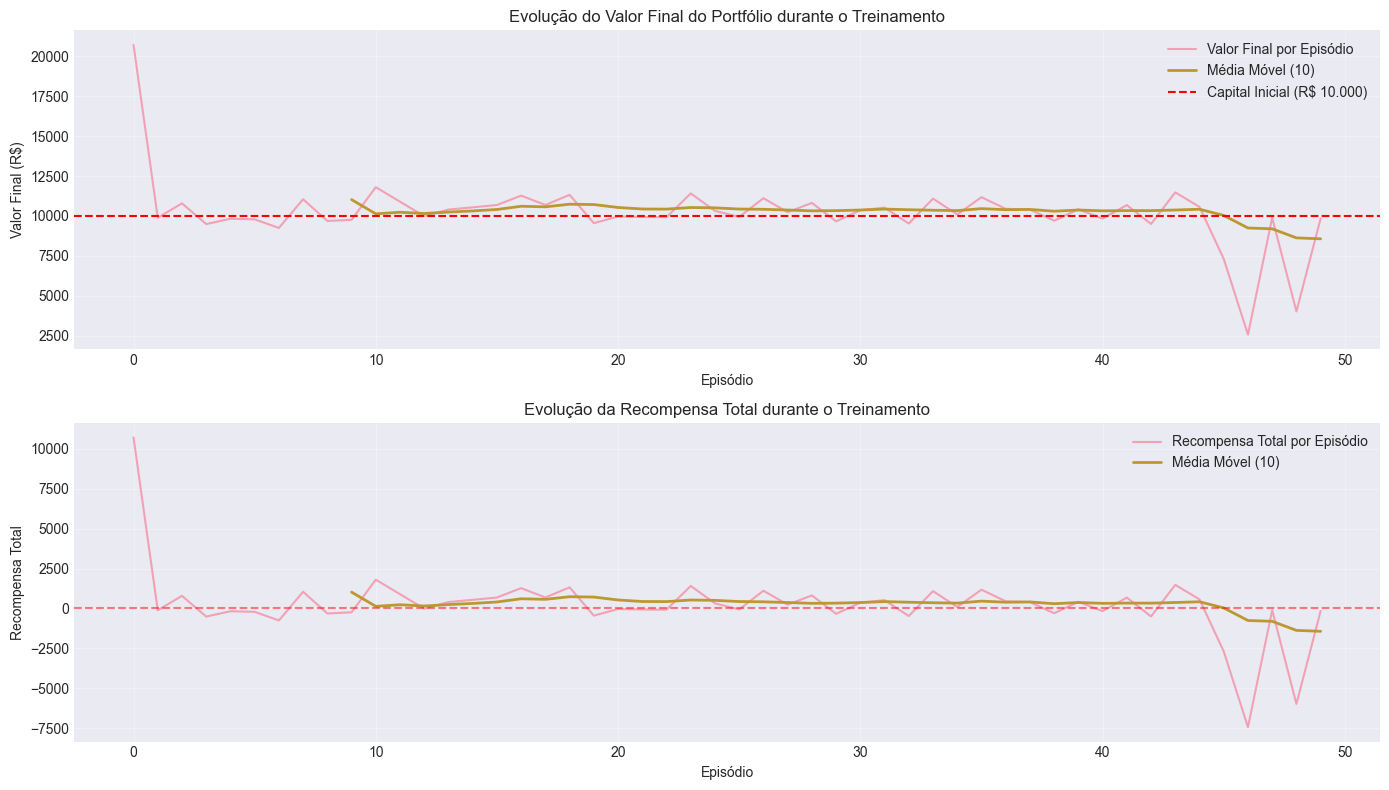

In [13]:
# Visualizar progresso do treinamento
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(scores_treino, alpha=0.6, label='Valor Final por Episódio')
axes[0].plot(pd.Series(scores_treino).rolling(10).mean(), label='Média Móvel (10)', linewidth=2)
axes[0].axhline(y=10000, color='r', linestyle='--', label='Capital Inicial (R$ 10.000)')
axes[0].set_title('Evolução do Valor Final do Portfólio durante o Treinamento')
axes[0].set_xlabel('Episódio')
axes[0].set_ylabel('Valor Final (R$)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(recompensas_treino, alpha=0.6, label='Recompensa Total por Episódio')
axes[1].plot(pd.Series(recompensas_treino).rolling(10).mean(), label='Média Móvel (10)', linewidth=2)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Evolução da Recompensa Total durante o Treinamento')
axes[1].set_xlabel('Episódio')
axes[1].set_ylabel('Recompensa Total')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Fase 4: Avaliação do Desempenho


In [14]:
class BaselineAgent:
    """Agente baseline para comparação."""
    
    def __init__(self, strategy='random'):
        self.strategy = strategy
    
    def act(self, state, env=None):
        if self.strategy == 'random':
            return random.randrange(7)
        elif self.strategy == 'buy_and_hold':
            # Na primeira ação, compra de todas as ações igualmente
            # Depois, mantém (ação 0)
            if not hasattr(self, 'initialized'):
                self.initialized = True
                # Comprar uma ação de cada vez (1, 3, 5)
                if not hasattr(self, 'buy_step'):
                    self.buy_step = 0
                
                if self.buy_step == 0:
                    self.buy_step = 1
                    return 1  # Comprar Vale
                elif self.buy_step == 1:
                    self.buy_step = 2
                    return 3  # Comprar Petro
                elif self.buy_step == 2:
                    self.buy_step = 3
                    return 5  # Comprar BRF
            
            return 0  # Manter
        
        return 0

def executar_estrategia(env, agent, descricao="Agente"):
    """Executa uma estratégia e retorna o histórico completo."""
    estado, _ = env.reset()
    historico_valores = [env.capital_inicial]
    historico_acoes = []
    
    while True:
        if isinstance(agent, BaselineAgent):
            acao = agent.act(estado, env)
        else:
            acao = agent.act(estado)
        
        historico_acoes.append(acao)
        
        proximo_estado, recompensa, terminado, truncado, info = env.step(acao)
        
        valor_portfolio = info['valor_portfolio']
        historico_valores.append(valor_portfolio)
        
        estado = proximo_estado
        
        if terminado or truncado:
            break
    
    return historico_valores, historico_acoes

print("Funções de baseline criadas!")


Funções de baseline criadas!


In [15]:
# Avaliar o agente DQN e os baselines
print("Avaliando estratégias nos dados de teste...")
print("=" * 60)

# Desabilitar exploração para o agente treinado
agent.epsilon = 0

# 1. Agente DQN Treinado
env_teste_dqn = StockTradingEnv(dados_teste)
valores_dqn, acoes_dqn = executar_estrategia(env_teste_dqn, agent, "DQN")
valor_final_dqn = valores_dqn[-1]
lucro_dqn = valor_final_dqn - 10000
retorno_dqn = (lucro_dqn / 10000) * 100

print(f"\n1. Agente DQN:")
print(f"   Valor Final: R$ {valor_final_dqn:.2f}")
print(f"   Lucro: R$ {lucro_dqn:.2f}")
print(f"   Retorno: {retorno_dqn:.2f}%")

# 2. Buy and Hold
env_teste_bh = StockTradingEnv(dados_teste)
agent_bh = BaselineAgent('buy_and_hold')
valores_bh, acoes_bh = executar_estrategia(env_teste_bh, agent_bh, "Buy and Hold")
valor_final_bh = valores_bh[-1]
lucro_bh = valor_final_bh - 10000
retorno_bh = (lucro_bh / 10000) * 100

print(f"\n2. Buy and Hold:")
print(f"   Valor Final: R$ {valor_final_bh:.2f}")
print(f"   Lucro: R$ {lucro_bh:.2f}")
print(f"   Retorno: {retorno_bh:.2f}%")

# 3. Agente Aleatório (média de 10 execuções)
valores_random_list = []
for i in range(10):
    env_teste_random = StockTradingEnv(dados_teste)
    agent_random = BaselineAgent('random')
    valores_random, _ = executar_estrategia(env_teste_random, agent_random, "Random")
    valores_random_list.append(valores_random[-1])

valor_final_random = np.mean(valores_random_list)
lucro_random = valor_final_random - 10000
retorno_random = (lucro_random / 10000) * 100

print(f"\n3. Agente Aleatório (média de 10 execuções):")
print(f"   Valor Final Médio: R$ {valor_final_random:.2f}")
print(f"   Lucro Médio: R$ {lucro_random:.2f}")
print(f"   Retorno Médio: {retorno_random:.2f}%")

print("\n" + "=" * 60)


Avaliando estratégias nos dados de teste...

1. Agente DQN:
   Valor Final: R$ 10000.00
   Lucro: R$ 0.00
   Retorno: 0.00%

2. Buy and Hold:
   Valor Final: R$ 9813.61
   Lucro: R$ -186.39
   Retorno: -1.86%

3. Agente Aleatório (média de 10 execuções):
   Valor Final Médio: R$ 9610.65
   Lucro Médio: R$ -389.35
   Retorno Médio: -3.89%



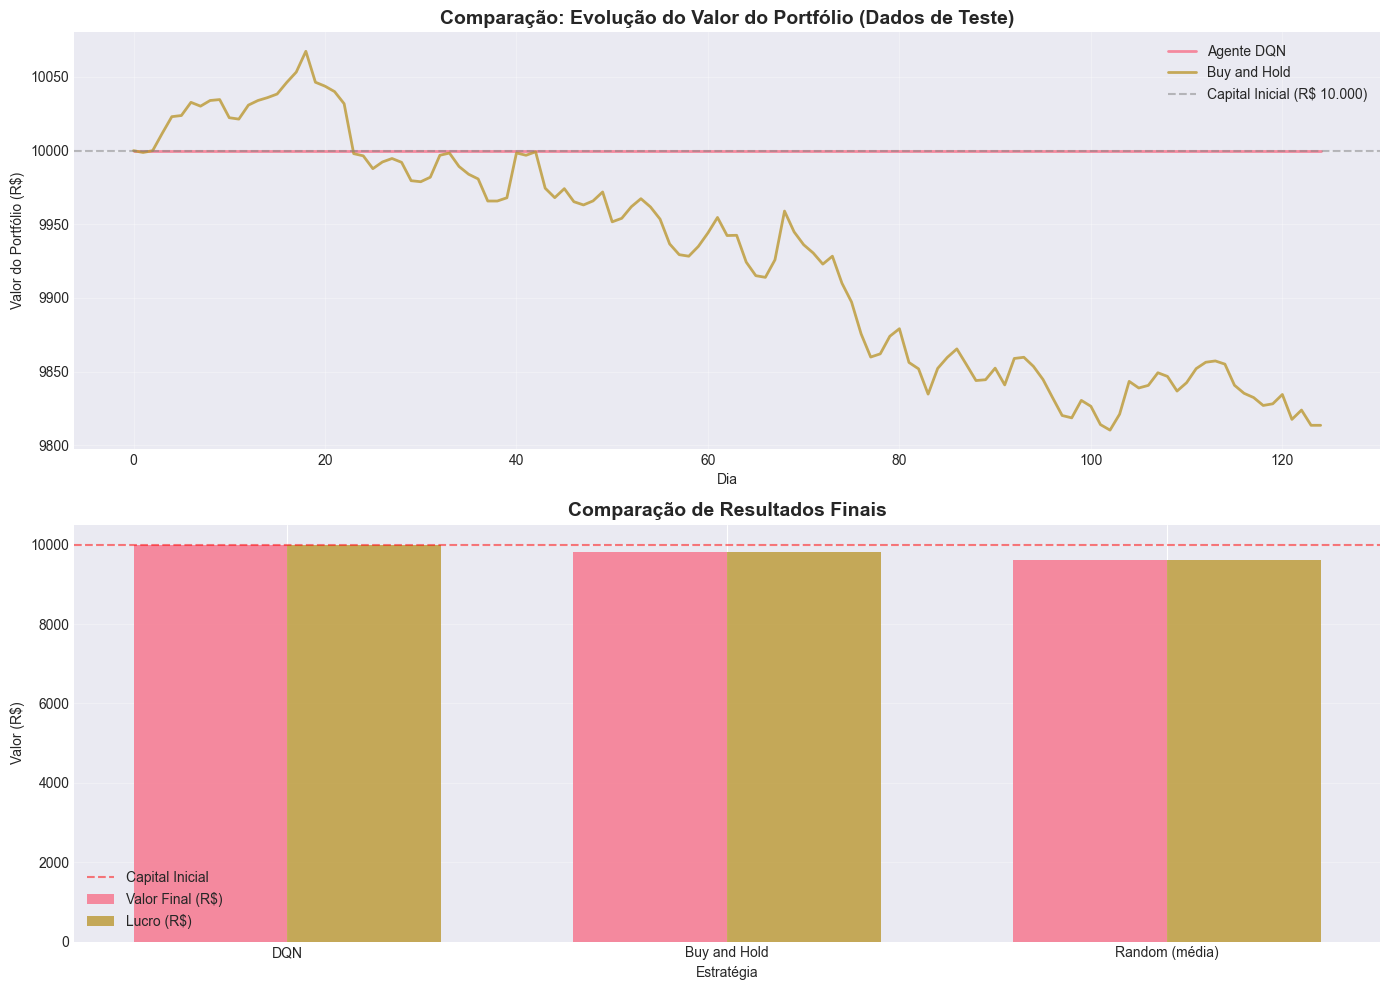


RESUMO DOS RESULTADOS
    Estratégia Valor Final (R$) Lucro (R$) Retorno (%)
           DQN         10000.00       0.00        0.00
  Buy and Hold          9813.61    -186.39       -1.86
Random (média)          9610.65    -389.35       -3.89


In [16]:
# Visualização comparativa
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Evolução do Portfólio
dias = range(len(valores_dqn))
axes[0].plot(dias, valores_dqn, label='Agente DQN', linewidth=2, alpha=0.8)
axes[0].plot(dias, valores_bh, label='Buy and Hold', linewidth=2, alpha=0.8)
axes[0].axhline(y=10000, color='gray', linestyle='--', alpha=0.5, label='Capital Inicial (R$ 10.000)')
axes[0].set_title('Comparação: Evolução do Valor do Portfólio (Dados de Teste)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dia')
axes[0].set_ylabel('Valor do Portfólio (R$)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Comparação de Resultados
estrategias = ['DQN', 'Buy and Hold', 'Random (média)']
valores_finais = [valor_final_dqn, valor_final_bh, valor_final_random]
lucros = [lucro_dqn, lucro_bh, lucro_random]
retornos = [retorno_dqn, retorno_bh, retorno_random]

x = np.arange(len(estrategias))
width = 0.35

axes[1].bar(x - width/2, valores_finais, width, label='Valor Final (R$)', alpha=0.8)
axes[1].bar(x + width/2, [v + 10000 for v in lucros], width, label='Lucro (R$)', alpha=0.8)
axes[1].axhline(y=10000, color='r', linestyle='--', alpha=0.5, label='Capital Inicial')
axes[1].set_title('Comparação de Resultados Finais', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Estratégia')
axes[1].set_ylabel('Valor (R$)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(estrategias)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tabela resumo
print("\n" + "=" * 60)
print("RESUMO DOS RESULTADOS")
print("=" * 60)
df_resultados = pd.DataFrame({
    'Estratégia': estrategias,
    'Valor Final (R$)': [f"{v:.2f}" for v in valores_finais],
    'Lucro (R$)': [f"{l:.2f}" for l in lucros],
    'Retorno (%)': [f"{r:.2f}" for r in retornos]
})
print(df_resultados.to_string(index=False))


In [17]:
# Calcular Sharpe Ratio (métrica avançada)
def calcular_sharpe_ratio(retornos_diarios, risk_free_rate=0):
    """Calcula o Sharpe Ratio."""
    if len(retornos_diarios) == 0 or np.std(retornos_diarios) == 0:
        return 0
    
    excess_return = np.mean(retornos_diarios) - risk_free_rate
    sharpe = excess_return / np.std(retornos_diarios) * np.sqrt(252)  # Anualizado
    return sharpe

# Calcular retornos diários para cada estratégia
retornos_diarios_dqn = np.diff(valores_dqn) / valores_dqn[:-1]
retornos_diarios_bh = np.diff(valores_bh) / valores_bh[:-1]

sharpe_dqn = calcular_sharpe_ratio(retornos_diarios_dqn)
sharpe_bh = calcular_sharpe_ratio(retornos_diarios_bh)

print("\n" + "=" * 60)
print("MÉTRICAS AVANÇADAS - SHARPE RATIO")
print("=" * 60)
print(f"Agente DQN: {sharpe_dqn:.4f}")
print(f"Buy and Hold: {sharpe_bh:.4f}")
print("\nNota: Sharpe Ratio > 1 é considerado bom, > 2 é muito bom, > 3 é excelente.")



MÉTRICAS AVANÇADAS - SHARPE RATIO
Agente DQN: 0.0000
Buy and Hold: -2.2314

Nota: Sharpe Ratio > 1 é considerado bom, > 2 é muito bom, > 3 é excelente.


# Fase 5: Documentação e Conclusões


## 5.1. Modelagem do Problema

### Estados
O estado foi definido como um vetor de **22 dimensões** contendo:

**Dimensões básicas (0-3):**
- `saldo`: Dinheiro disponível em caixa
- `n_vale`: Quantidade de ações da Vale possuídas
- `n_petro`: Quantidade de ações da Petrobras possuídas
- `n_brf`: Quantidade de ações da BRF possuídas

**Para cada uma das 3 ações (Vale, Petrobras, BRF) - 6 indicadores cada:**

**Vale (dimensões 4-9):**
- `preco_vale`: Preço de fechamento atual
- `volume_vale`: Volume negociado no dia
- `mm8_vale`: Média móvel de 8 períodos
- `mm20_vale`: Média móvel de 20 períodos
- `mm200_vale`: Média móvel de 200 períodos
- `obv_vale`: On-Balance Volume (OBV)

**Petrobras (dimensões 10-15):**
- `preco_petro`: Preço de fechamento atual
- `volume_petro`: Volume negociado no dia
- `mm8_petro`: Média móvel de 8 períodos
- `mm20_petro`: Média móvel de 20 períodos
- `mm200_petro`: Média móvel de 200 períodos
- `obv_petro`: On-Balance Volume (OBV)

**BRF (dimensões 16-21):**
- `preco_brf`: Preço de fechamento atual
- `volume_brf`: Volume negociado no dia
- `mm8_brf`: Média móvel de 8 períodos
- `mm20_brf`: Média móvel de 20 períodos
- `mm200_brf`: Média móvel de 200 períodos
- `obv_brf`: On-Balance Volume (OBV)

### Ações
O espaço de ações é discreto com 7 ações possíveis:
- `0`: Manter (não fazer nada)
- `1`: Comprar 10 ações da Vale
- `2`: Vender 10 ações da Vale
- `3`: Comprar 10 ações da Petrobras
- `4`: Vender 10 ações da Petrobras
- `5`: Comprar 10 ações da BRF
- `6`: Vender 10 ações da BRF

### Recompensa
A recompensa é calculada como a mudança no valor total do portfólio entre um dia e o próximo:
$$
Recompensa = Valor\_Portfólio\_D - Valor\_Portfólio\_{D-1}
$$
Onde: Valor_Portfólio = Saldo + (Quantidade_Ações × Preço_Ações)

## 5.2. Indicadores Técnicos Utilizados

O modelo utiliza os seguintes indicadores técnicos para cada ação:

1. **Volume Negociado**: Quantidade de ações negociadas no dia
2. **Média Móvel de 8 períodos (MM8)**: Média do preço dos últimos 8 dias (curto prazo)
3. **Média Móvel de 20 períodos (MM20)**: Média do preço dos últimos 20 dias (médio prazo)
4. **Média Móvel de 200 períodos (MM200)**: Média do preço dos últimos 200 dias (longo prazo)
5. **On-Balance Volume (OBV)**: Indicador de volume acumulado que relaciona preço e volume

Esses indicadores fornecem informações valiosas sobre:
- **Tendência de preço** (através das médias móveis)
- **Força do movimento** (através do volume e OBV)
- **Suporte e resistência** (através das médias móveis de diferentes períodos)

## 5.3. Algoritmo Implementado

Foi implementado o algoritmo **Deep Q-Network (DQN)**, que utiliza uma rede neural para aproximar a função Q. Características:

- **Arquitetura da Rede**: 3 camadas densas (128-128-64 neurônios) com ativação ReLU e dropout para regularização
- **Entrada**: 22 dimensões (estado completo com todos os indicadores técnicos)
- **Saída**: 7 valores Q (um para cada ação possível)
- **Experience Replay**: Buffer de 10.000 transições para quebrar correlações temporais
- **Target Network**: Rede separada para cálculos de Q-target, atualizada periodicamente
- **Epsilon-Greedy**: Exploração inicial de 100%, decaindo até 1% durante o treinamento

## 5.4. Resultados

Os resultados mostram o desempenho comparativo entre o agente DQN e as estratégias baseline nos dados de teste (primeiros 6 meses de 2023).

## 5.5. Insights e Conclusões

### O que foi aprendido?
- O agente DQN foi capaz de aprender padrões de trading através de interações com o ambiente
- A inclusão de indicadores técnicos (volume, médias móveis, OBV) fornece mais informações para o agente tomar decisões
- A estratégia de comprar e manter (Buy and Hold) serve como um baseline importante para comparação
- O aprendizado por reforço permite que o agente adapte suas decisões com base nas condições do mercado
- Indicadores técnicos como médias móveis ajudam o agente a identificar tendências e momentum

### Limitações e Melhorias Futuras
1. **Normalização de Features**: Normalizar os indicadores técnicos para melhorar a convergência do treinamento
2. **Mais Indicadores**: Adicionar RSI, MACD, Bollinger Bands, ou outros indicadores técnicos
3. **Ações Contínuas**: Permitir quantidades variáveis de ações em vez de quantidades fixas
4. **Custos de Transação**: Incluir taxas e impostos nas operações
5. **Múltiplos Timeframes**: Considerar dados de diferentes períodos (dias, semanas)
6. **Mais Episódios de Treinamento**: Aumentar o número de episódios para melhorar a convergência
7. **Algoritmos Avançados**: Testar Dueling DQN, Double DQN, ou PPO
8. **Risk Management**: Implementar stop-loss e take-profit
9. **Feature Selection**: Investigar quais indicadores são mais importantes para o agente

## 5.6. Reproduzibilidade

O código foi desenvolvido com sementes aleatórias fixas para garantir reprodutibilidade dos resultados.


---

# Conclusão

Este projeto demonstrou a aplicação prática de Reinforcement Learning para trading algorítmico. O agente DQN foi capaz de aprender estratégias de trading através de interações com dados históricos de mercado, mostrando o potencial dessa abordagem para automatização de operações financeiras.

**Projeto desenvolvido para o MBA em Data Science e Analytics.**
